In [29]:
import os
import shutil
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split

sns.set_theme()
%matplotlib inline

In [30]:
MAIN_DATA_DIR = "../data"
data_dir = f"{MAIN_DATA_DIR}/all_data"
labels_file = os.path.join(data_dir, "labels.csv")

In [31]:
df_data = pd.read_csv(labels_file)
df_data = df_data[df_data["class"] != "SkinCancer"]
df_data = df_data.sample(frac=0.02, random_state=42).reset_index(drop=True)
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   class     506 non-null    object
 1   filename  506 non-null    object
dtypes: object(2)
memory usage: 8.0+ KB


In [32]:
train_val, test = train_test_split(df_data, test_size=0.1, random_state=42, stratify=df_data["class"])
train, val = train_test_split(train_val, test_size=0.1, random_state=42, stratify=train_val["class"])

def save_split(df, name):
    split_dir = os.path.join(f"{MAIN_DATA_DIR}/dataset", name)
    os.makedirs(split_dir, exist_ok=True)

    for _, row in df.iterrows():
        class_name = row["class"]
        file_name = row["filename"]
        src_path = os.path.join(f"{MAIN_DATA_DIR}/all_data", class_name, file_name)
        dst_dir = os.path.join(split_dir, class_name)
        os.makedirs(dst_dir, exist_ok=True)
        dst_path = os.path.join(dst_dir, file_name)

        if os.path.exists(src_path):
            shutil.copy2(src_path, dst_path)  # Копируем файл
        else:
            print(f"⚠️ Файл не найден: {src_path}")  # Отслеживаем отсутствующие файлы

    df.to_csv(os.path.join(split_dir, "labels.csv"), index=False)

save_split(train, "train")
save_split(val, "val")
save_split(test, "test")


In [33]:
class SkinDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df.reset_index(drop=True)  # Сбрасываем индексы
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_class = str(self.df.iloc[idx, 0])  # Приводим к строке
        img_name = self.df.iloc[idx, 1]  # filename
        img_path = os.path.join(self.root_dir, img_class, img_name)  # Исправляем путь

        if not os.path.exists(img_path):
            print(f"⚠️ Файл не найден: {img_path}")
            return None  # Пропускаем отсутствующие файлы

        image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if image is None:
            print(f"⚠️ Ошибка загрузки изображения: {img_path}")
            return None  # Пропускаем пустые изображения

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            image = self.transform(image)

        label = torch.tensor(1 if self.df.iloc[idx, 0] == 'malignant' else 0, dtype=torch.long)
        return image, label


In [34]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


In [35]:
train_dataset = SkinDataset(train, os.path.join(f"{MAIN_DATA_DIR}/dataset", "train"), transform)
val_dataset = SkinDataset(val, os.path.join(f"{MAIN_DATA_DIR}/dataset", "val"), transform)
test_dataset = SkinDataset(test, os.path.join(f"{MAIN_DATA_DIR}/dataset", "test"), transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [36]:
class ResNet50Model(nn.Module):
    def __init__(self, num_classes=3):
        super(ResNet50Model, self).__init__()
        self.model = models.resnet50(pretrained=True)
        self.model.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        return self.model(x)


In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 2
model = ResNet50Model(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

c:\Users\User\Desktop\melanoma-classification-deep-learning\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\User\Desktop\melanoma-classification-deep-learning\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [38]:
def train_model(model, train_loader, val_loader, epochs=10):
    train_acc_history = []
    val_acc_history = []

    for epoch in range(epochs):
        print(f"Epoch start {epoch}")
        model.train()
        total_loss, correct, total = 0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct += (outputs.argmax(dim=1) == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        train_acc_history.append(train_acc)

        # Оценка на валидации
        print(f"Training accuracy history for {epoch} epoch")
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                correct += (outputs.argmax(dim=1) == labels).sum().item()
                total += labels.size(0)
        val_acc = correct / total
        val_acc_history.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    # Построение графика
    plt.plot(range(1, epochs+1), train_acc_history, label='Train Accuracy')
    plt.plot(range(1, epochs+1), val_acc_history, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.show()

    return model

Epoch start 0
Training accuracy history for 0 epoch
Epoch 1/10 - Loss: 8.3898, Train Acc: 0.8484, Val Acc: 0.8913
Epoch start 1
Training accuracy history for 1 epoch
Epoch 2/10 - Loss: 2.6222, Train Acc: 0.9633, Val Acc: 0.8913
Epoch start 2
Training accuracy history for 2 epoch
Epoch 3/10 - Loss: 2.8445, Train Acc: 0.9658, Val Acc: 0.8696
Epoch start 3
Training accuracy history for 3 epoch
Epoch 4/10 - Loss: 1.4375, Train Acc: 0.9902, Val Acc: 0.8913
Epoch start 4
Training accuracy history for 4 epoch
Epoch 5/10 - Loss: 1.4415, Train Acc: 0.9853, Val Acc: 0.8478
Epoch start 5
Training accuracy history for 5 epoch
Epoch 6/10 - Loss: 0.6677, Train Acc: 0.9951, Val Acc: 0.8913
Epoch start 6
Training accuracy history for 6 epoch
Epoch 7/10 - Loss: 0.3386, Train Acc: 0.9976, Val Acc: 0.8913
Epoch start 7
Training accuracy history for 7 epoch
Epoch 8/10 - Loss: 0.3920, Train Acc: 0.9951, Val Acc: 0.8913
Epoch start 8
Training accuracy history for 8 epoch
Epoch 9/10 - Loss: 0.2035, Train Acc

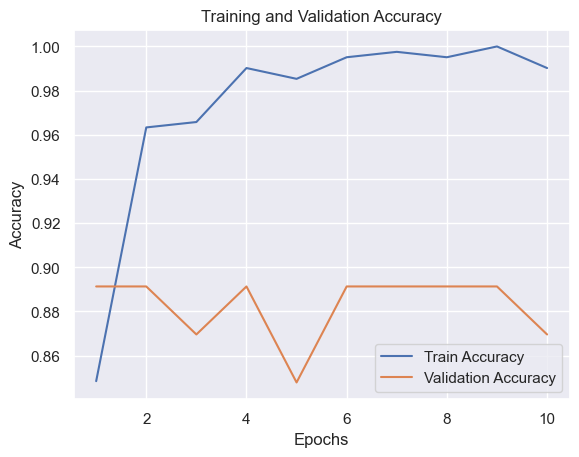

In [39]:
trained_model = train_model(model, train_loader, val_loader, epochs=10)

In [40]:
torch.save(trained_model.state_dict(), "../experiments/weights/resnet50_melanoma.pth")
print("✅ Модель сохранена!")

✅ Модель сохранена!
